In [1]:
import settings
from models import *
from epmt_job import setup_orm_db
import fnmatch

setup_orm_db()


In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
rcParams['figure.figsize'] = [15, 8]

def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()



In [29]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print "not found",e
        return None
    print "Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads"
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

In [30]:
js = get_job_list()
for j in js:
    print j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s."


20294924.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.246671 to 2019-02-15 19:03:26.082247 by Jeffrey.Durachta took 4486.835576 s.
20294925.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250163 to 2019-02-15 18:56:55.801626 by Jeffrey.Durachta took 4096.551463 s.
20294926.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250799 to 2019-02-15 19:12:04.238002 by Jeffrey.Durachta took 5004.987203 s.
20294927.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.255221 to 2019-02-15 18:53:16.331338 by Jeffrey.Durachta took 3877.076117 s.
20294929.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250164 to 2019-02-15 18:41:00.026465 by Jeffrey.Durachta took 3140.776301 s.
20294930.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.247442 to 2019-02-15 18:17:11.148370 by Jeffrey.Durachta took 1711.900928 s.
20294931.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.249980 to 2019-02-15 19:09:26.921158 by Jeffrey.Durachta took 4847.67

Found job 20294924.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


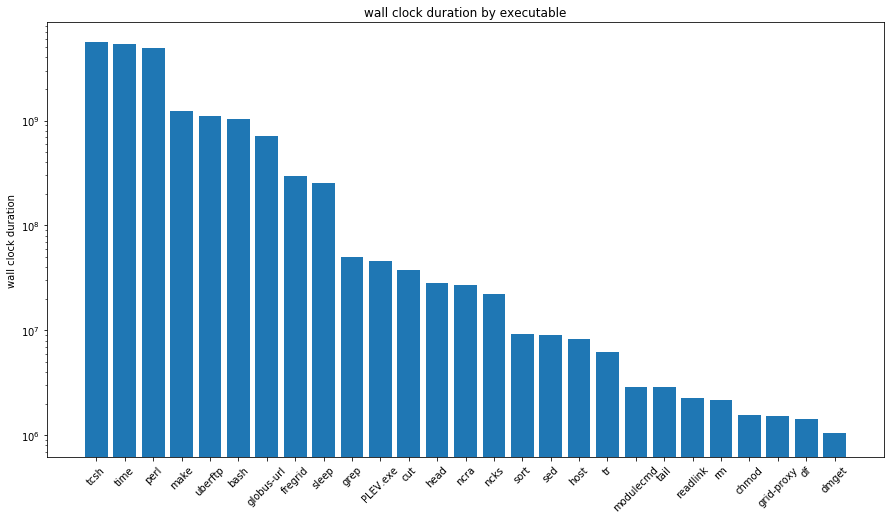

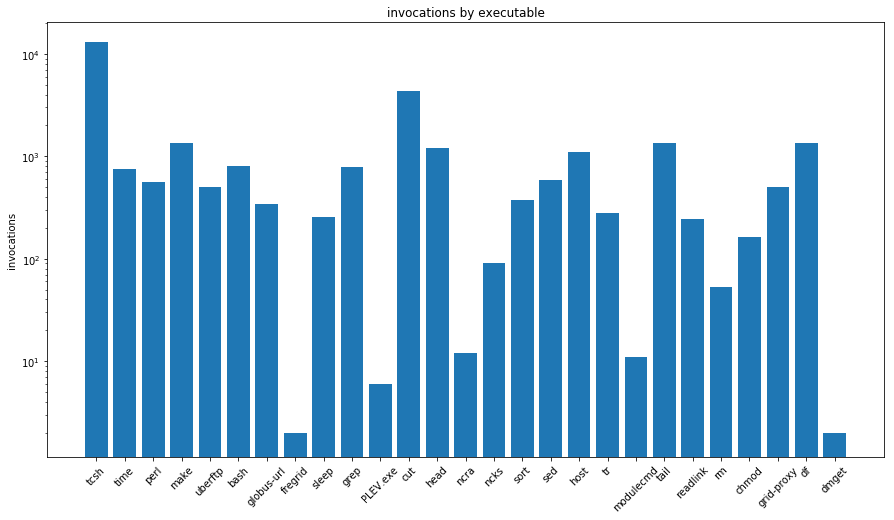

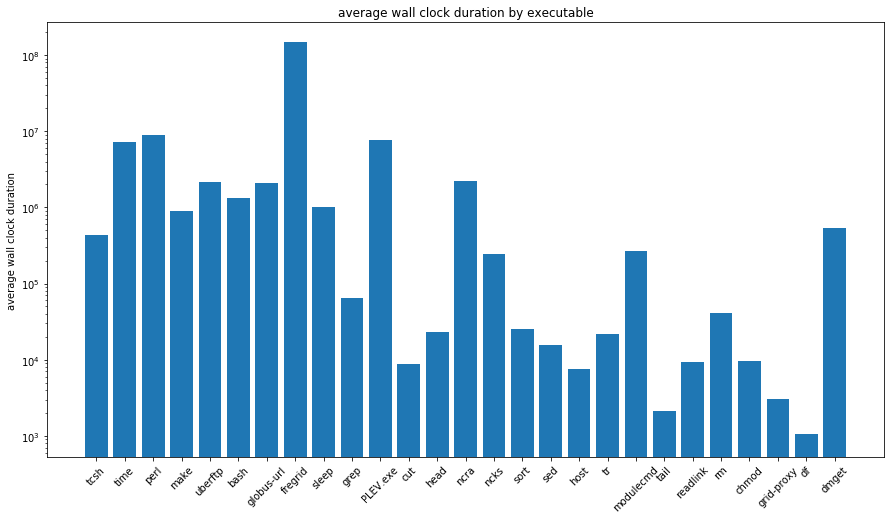

In [31]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



In [32]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

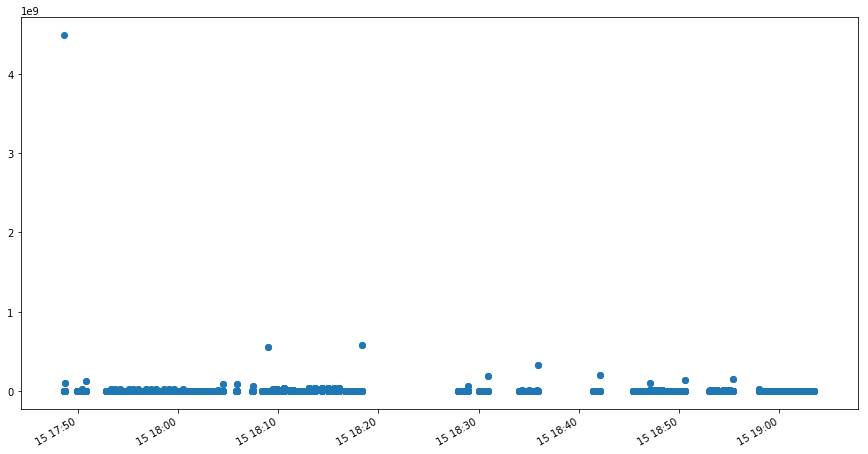

['duration', 'time']
<type 'numpy.int64'>


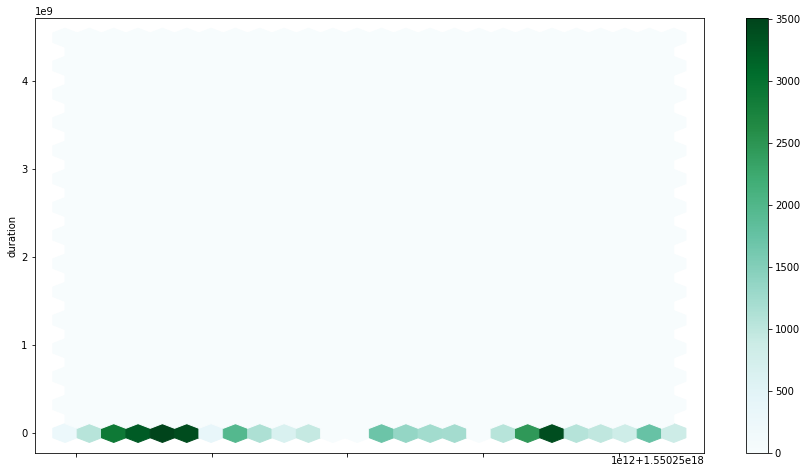

In [33]:
a = get_processes_job_filter(jobid=j)    
b = zip(*a)
plt.plot([],[])
plt.scatter(b[1],b[2])
plt.gcf().autofmt_xdate()
plt.show()

df = pd.DataFrame( { 'time': b[1], 'duration': b[2] })
df['time'] = pd.to_numeric(df['time'])
df.plot.hexbin(x='time', y='duration', gridsize=25)

#    value["duration"]
    #y_val.append()
#    print value["start"]
    #x_val.append(value["start"])

#x_val = [i for i in range(len(y_val))]
#print x_val, len(y_val)
##barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")
#barplot(labels=labels,y_val=y_val,mn="wall clock duration")
#barplot(labels=labels,y_val=y_val2,mn="invocations")

In [149]:
def compute_quantiles(frame):
    retval = frame.quantile([.5,.999])
    return retval

def get_outliers(pdf, metric):
    frame_quantiles = compute_quantiles(pdf[metric])
    return pdf[pdf[metric] > frame_quantiles[.999]]

def print_outliers(d, metric):
    if len(d.index):
        print "\t",len(d.index),"outliers in metric",metric,"mean",d[metric].describe()["mean"] 
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print "\t",thr,proc,proc.exename+"("+str(proc.pid)+") at",proc.start,metric,row[metric]
        
def remove_outliers(dfi, dfol):
#    print len(dfi),list(dfi)
#    print len(dfol),list(dfol)
    dfi = dfi[~dfi.thread.isin(dfol.thread)]
#    print len(dfi)
    return dfi




Job[u'20294924.moab01.princeton.rdhpcs.noaa.gov']
Process[36934] chmod on pp201- at 2019-02-15 17:59:57.116587 for 9431.0


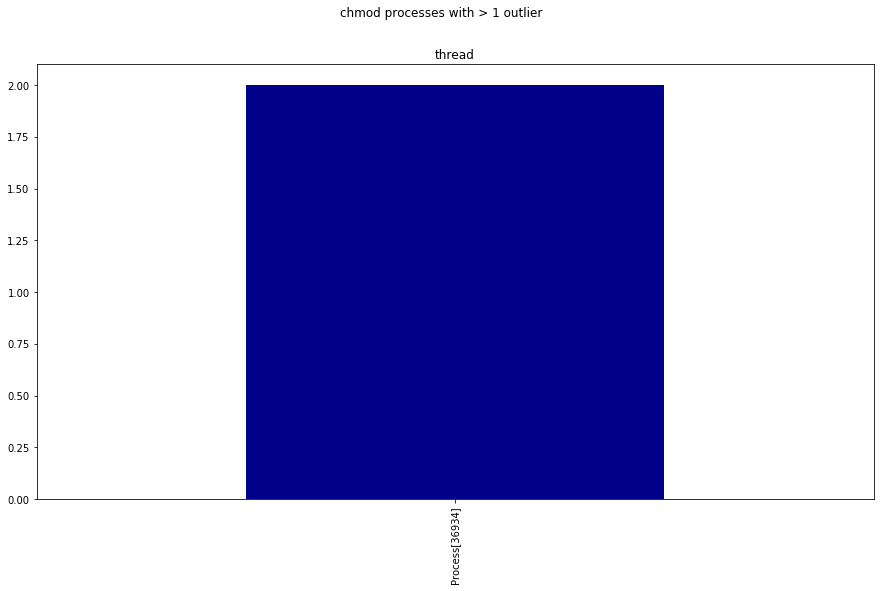

Process[11030] cut on pp201- at 2019-02-15 18:08:57.305089 for 19983.0
Process[35469] cut on pp201- at 2019-02-15 17:56:09.240242 for 98.0


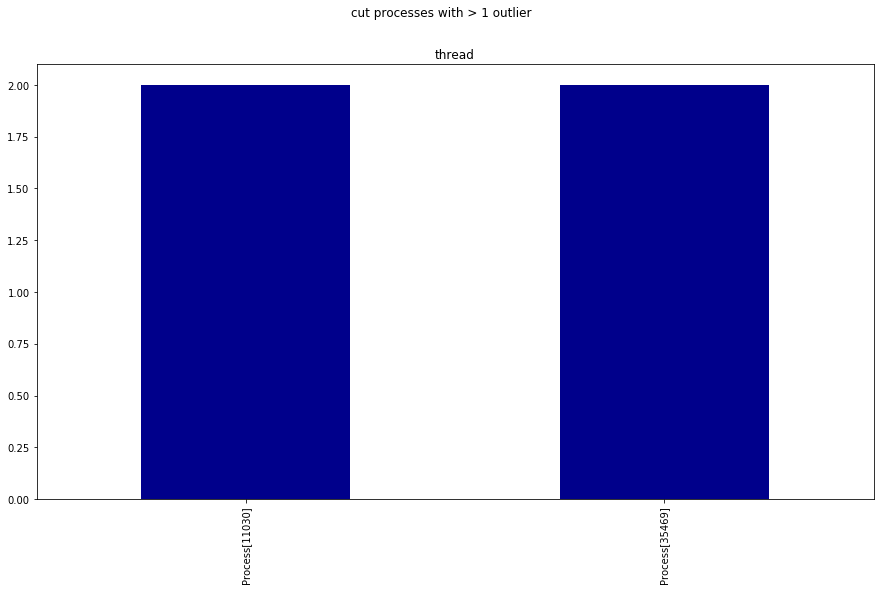

Process[17375] dmget on pp201- at 2019-02-15 18:55:12.728591 for 449566.0


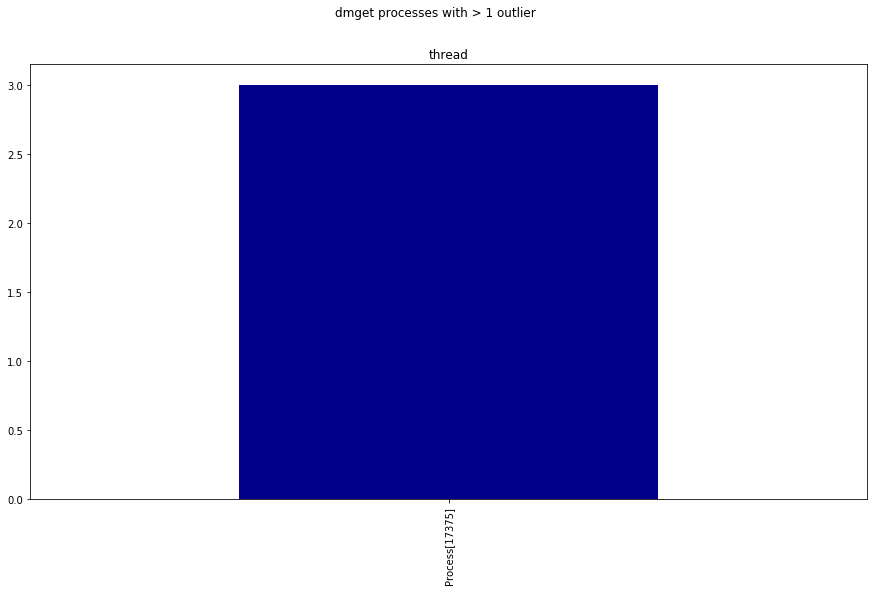

Process[25260] du on pp201- at 2019-02-15 18:54:02.655352 for 581183.0


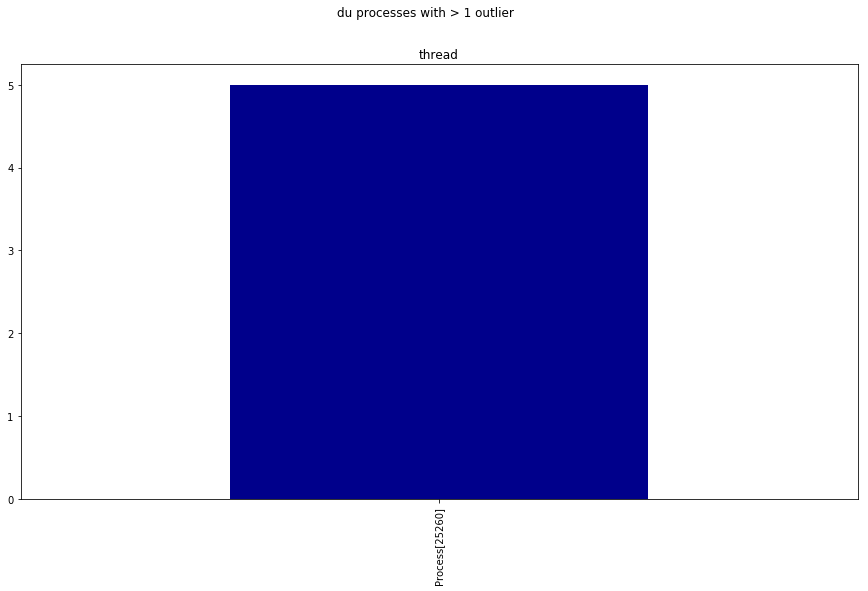

Process[5872] expr on pp201- at 2019-02-15 18:54:20.704382 for 238.0


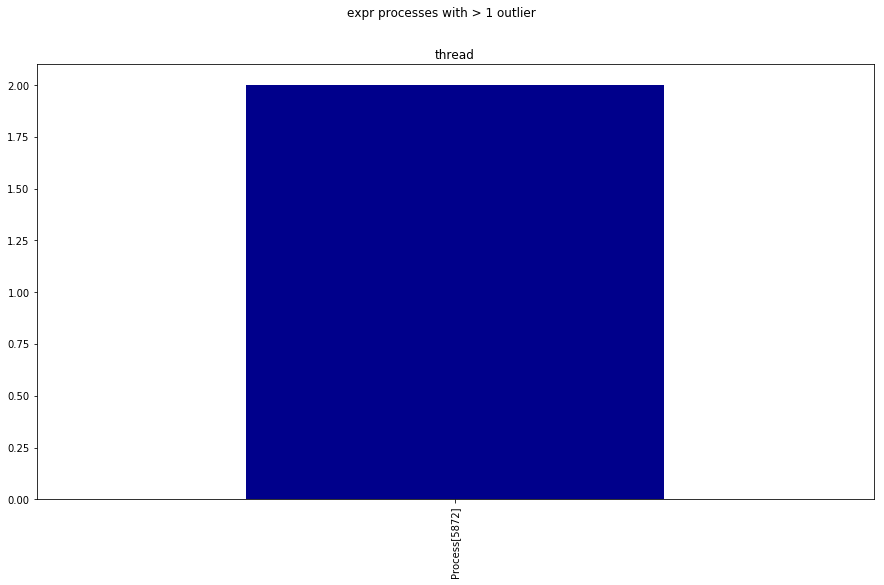

Process[16737] fregrid on pp201- at 2019-02-15 18:55:22.164053 for 153416473.0


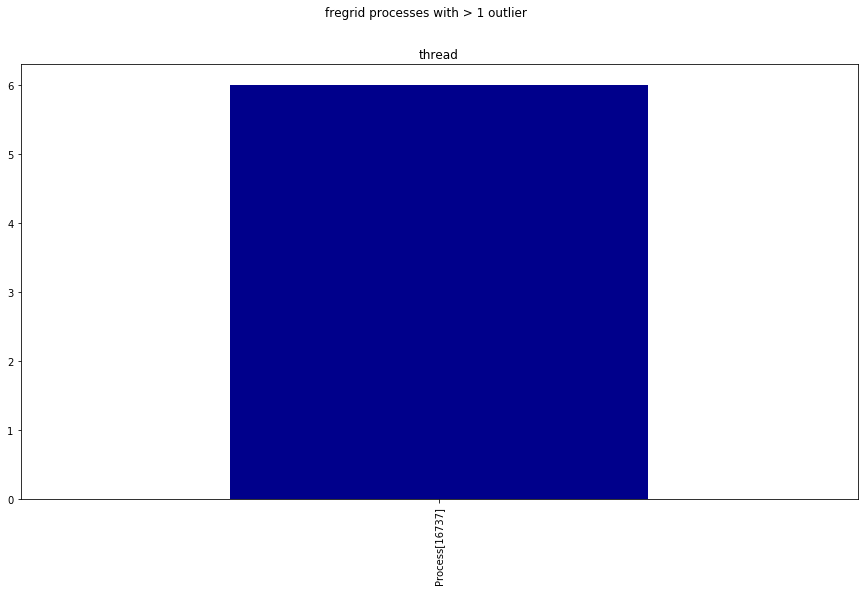

Process[28033] globus-url-copy on pp201- at 2019-02-15 18:13:38.521338 for 40044529.0


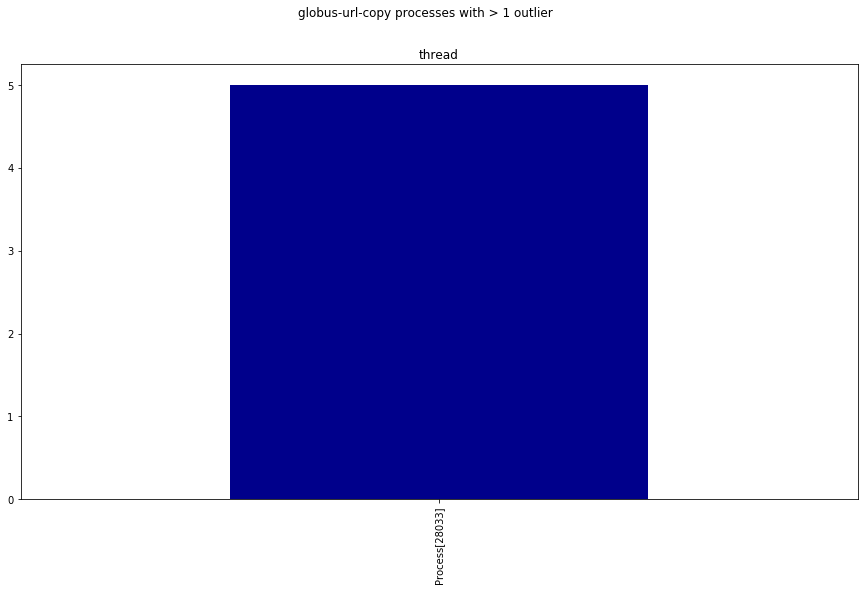

Process[33574] grid-proxy-info on pp201- at 2019-02-15 18:15:31.387307 for 4899.0


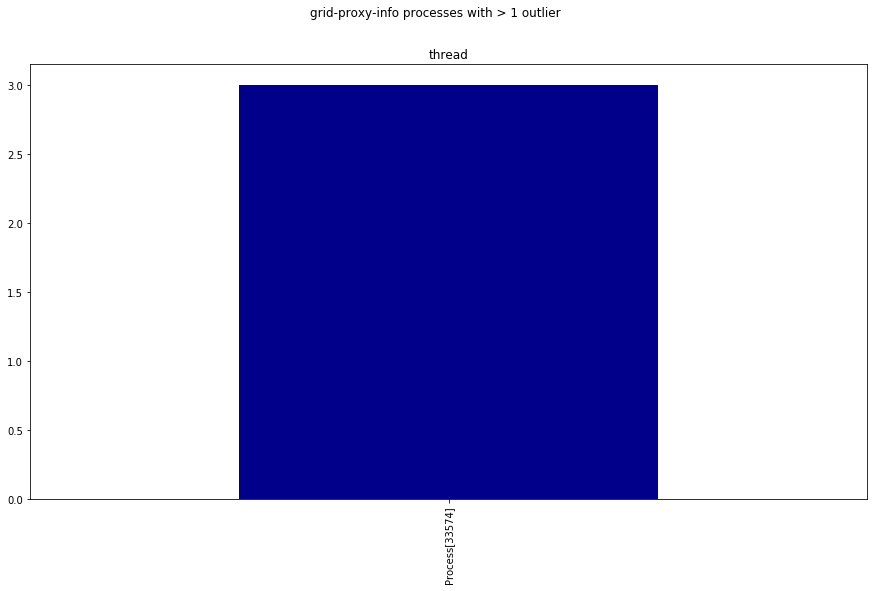

Process[29269] host on pp201- at 2019-02-15 18:01:45.669216 for 7788.0
Process[6096] host on pp201- at 2019-02-15 18:05:46.188981 for 8046.0
Process[22498] host on pp201- at 2019-02-15 17:59:23.303867 for 9548.0


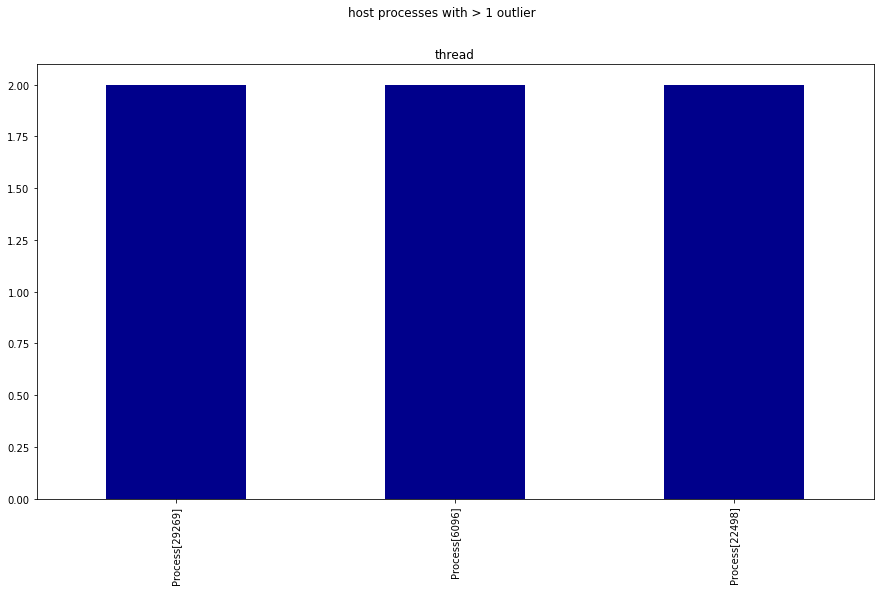

Process[29899] list_ncvars.exe on pp201- at 2019-02-15 18:50:28.651829 for 454.0


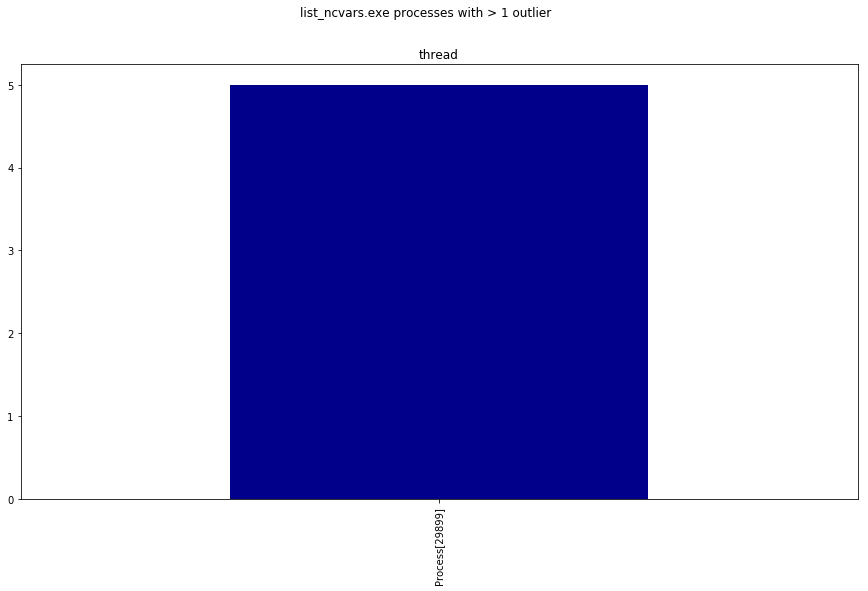

Process[18535] logger on pp201- at 2019-02-15 17:48:40.206093 for 1479.0
Process[22273] logger on pp201- at 2019-02-15 17:48:39.794008 for 1335.0


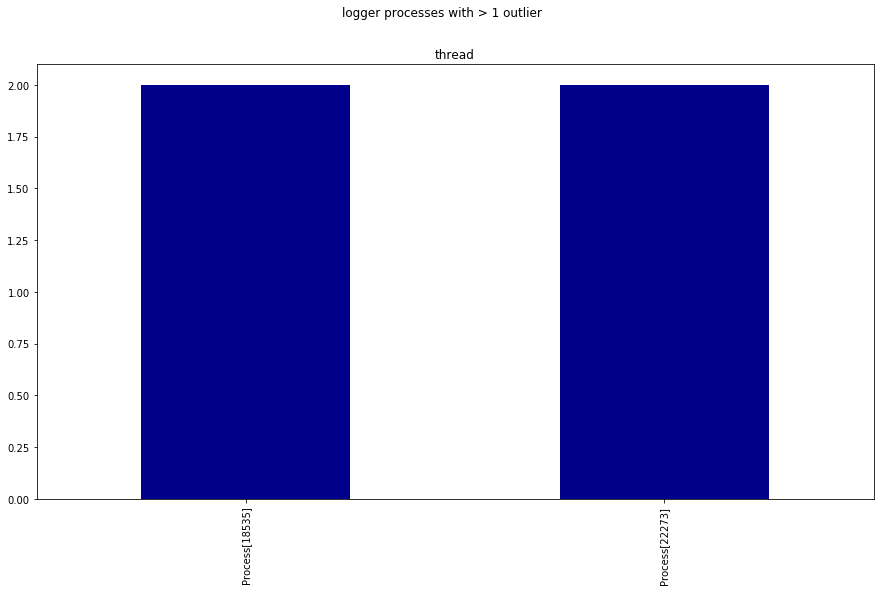

Process[13004] ls on pp201- at 2019-02-15 17:50:25.745466 for 31448.0


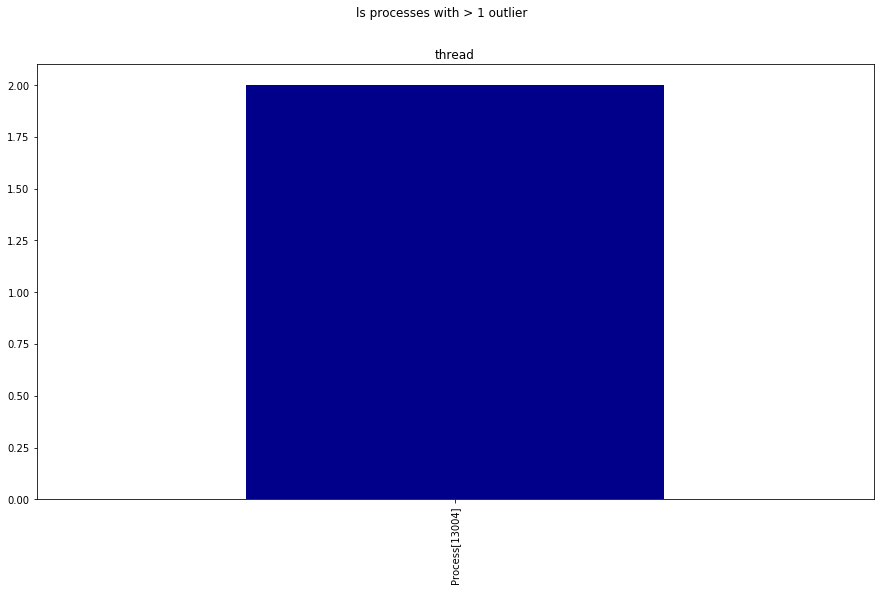

Process[7341] make on pp201- at 2019-02-15 18:27:55.309793 for 592953.0


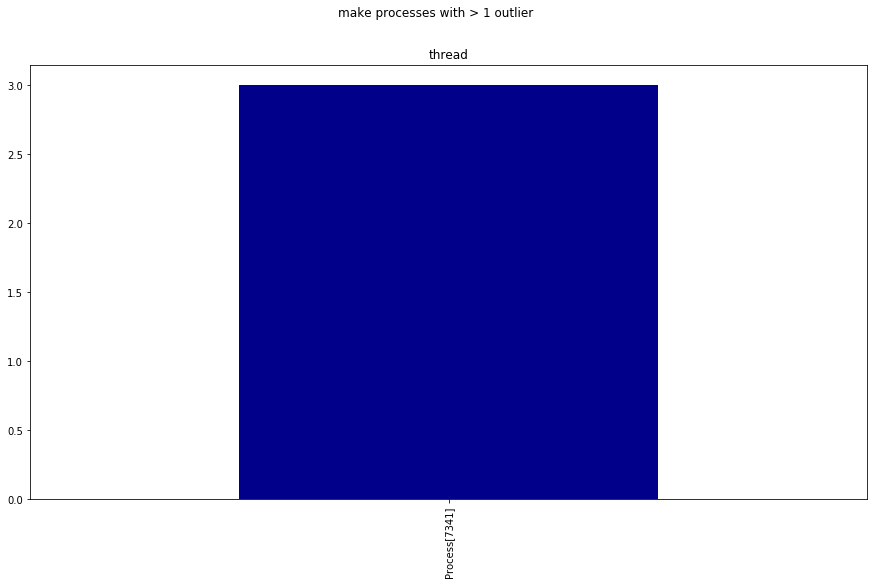

Process[15307] modulecmd on pp201- at 2019-02-15 17:48:39.408947 for 972801.0


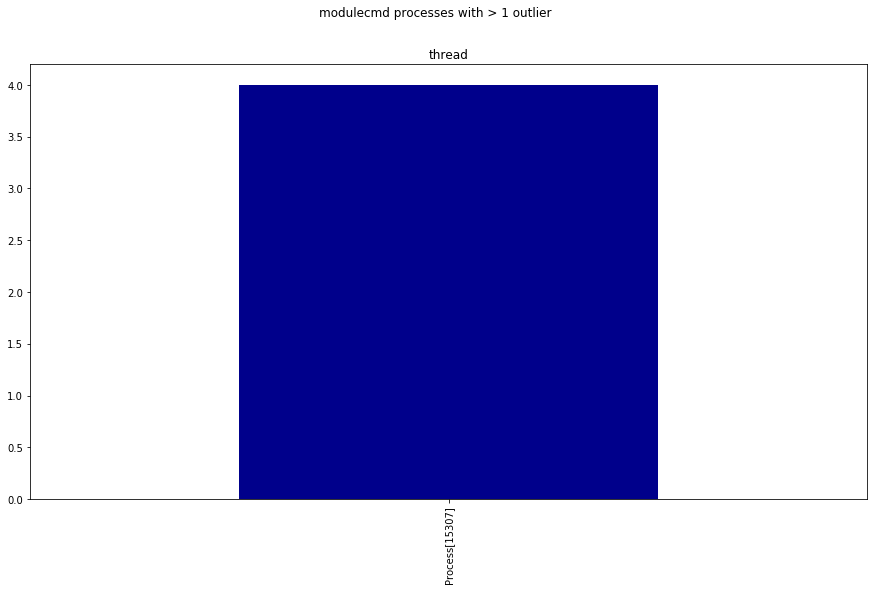

Process[5917] mv on pp201- at 2019-02-15 18:57:56.413456 for 574524.0


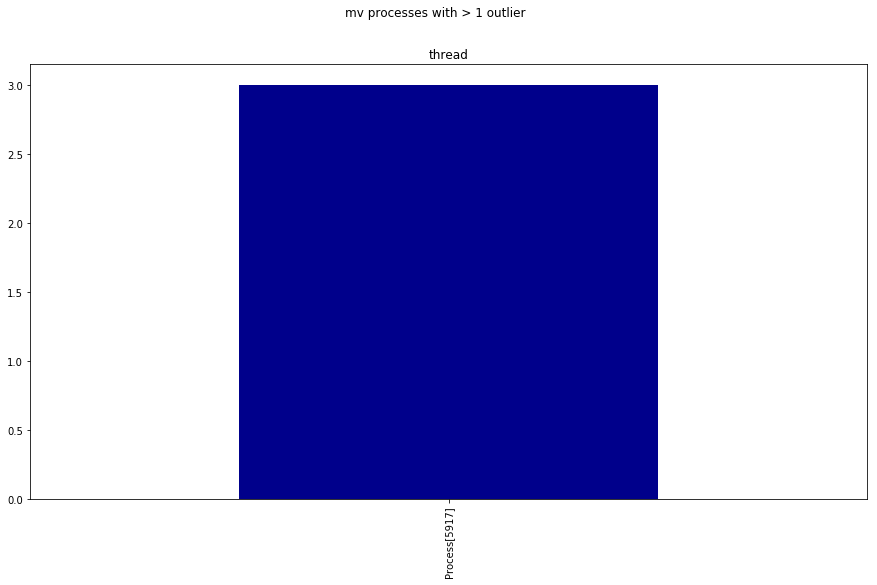

Process[34426] ncdump on pp201- at 2019-02-15 18:28:00.275830 for 406.0


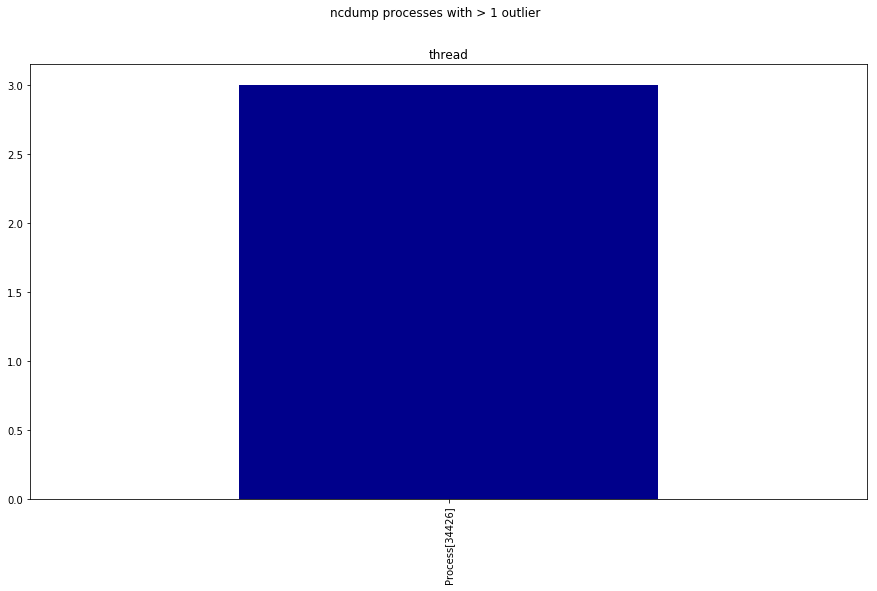

Process[2062] ncks on pp201- at 2019-02-15 18:53:05.165014 for 3208296.0


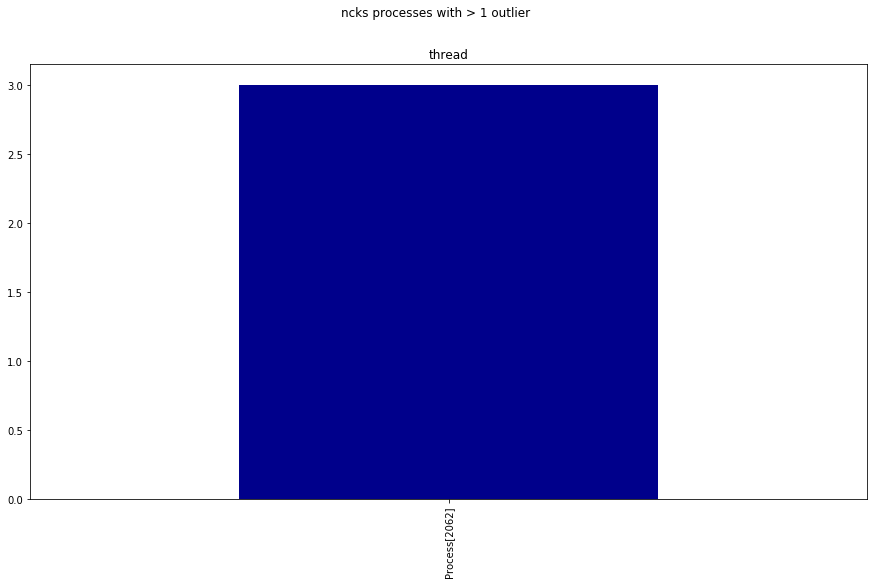

Process[21351] ncra on pp201- at 2019-02-15 18:50:16.235700 for 2181332.0
Process[9658] ncra on pp201- at 2019-02-15 18:54:17.505478 for 2691081.0


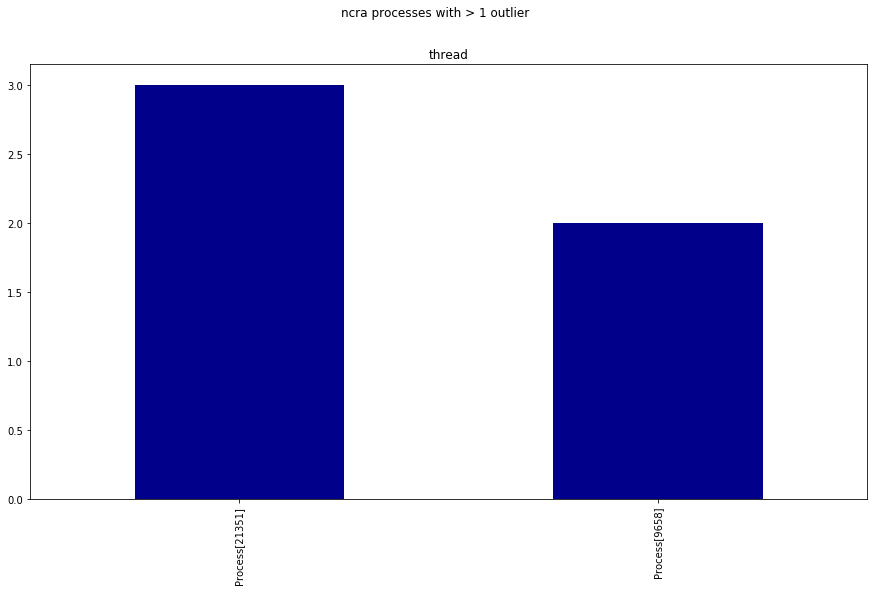

Process[16211] perl on pp201- at 2019-02-15 19:03:23.555020 for 2510372.0


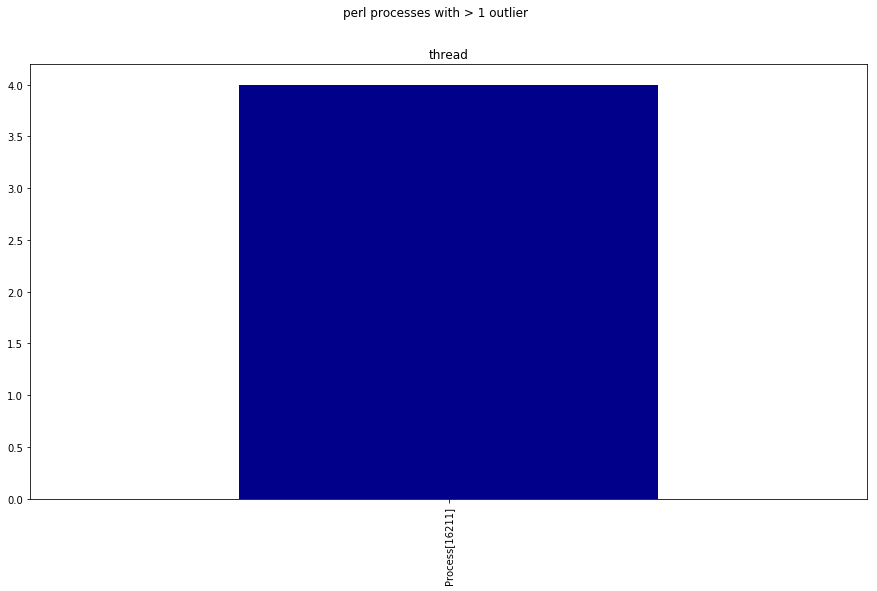

Process[16466] PLEV.exe on pp201- at 2019-02-15 18:54:38.455835 for 7885811.0
Process[9355] PLEV.exe on pp201- at 2019-02-15 18:54:20.883678 for 7916378.0


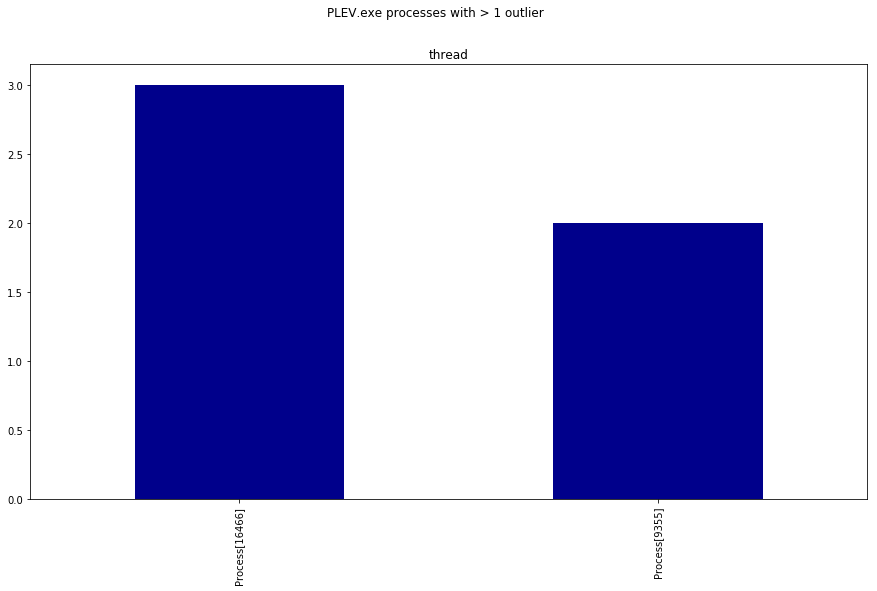

Process[17901] python on pp201- at 2019-02-15 17:48:42.211471 for 78.0


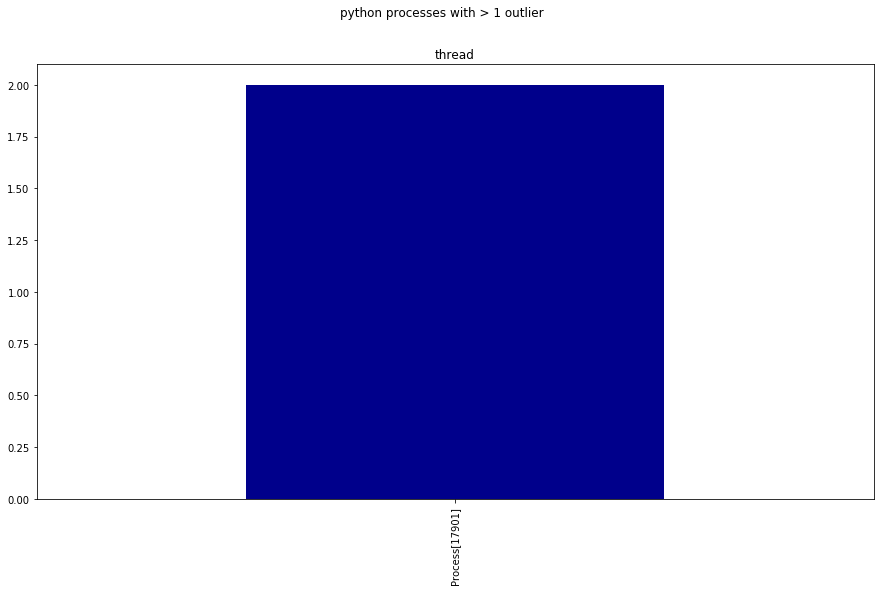

Process[22304] rm on pp201- at 2019-02-15 18:57:55.712662 for 620611.0
Process[35998] rm on pp201- at 2019-02-15 18:53:00.748565 for 628900.0


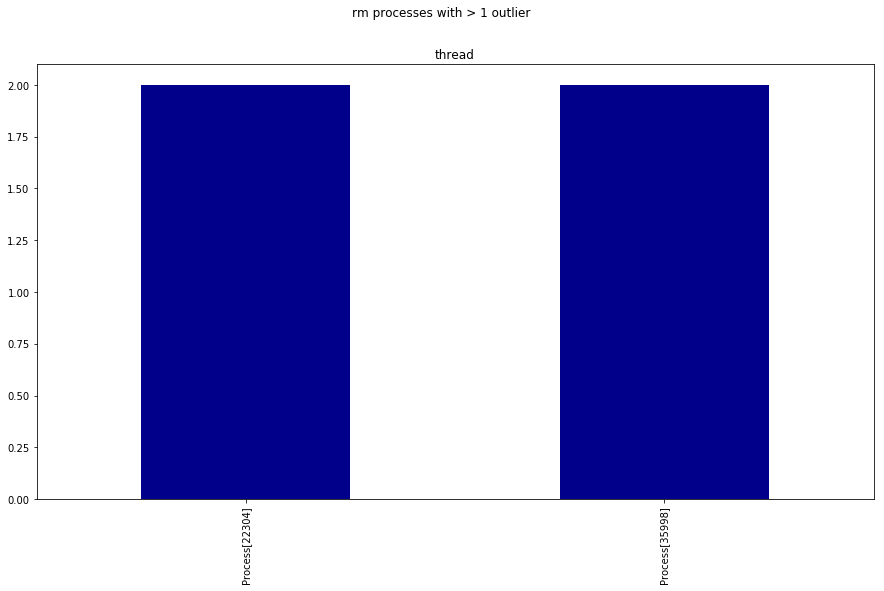

Process[21094] sleep on pp201- at 2019-02-15 18:14:55.124644 for 1000199.0
Process[22963] sleep on pp201- at 2019-02-15 18:47:31.817782 for 1000308.0


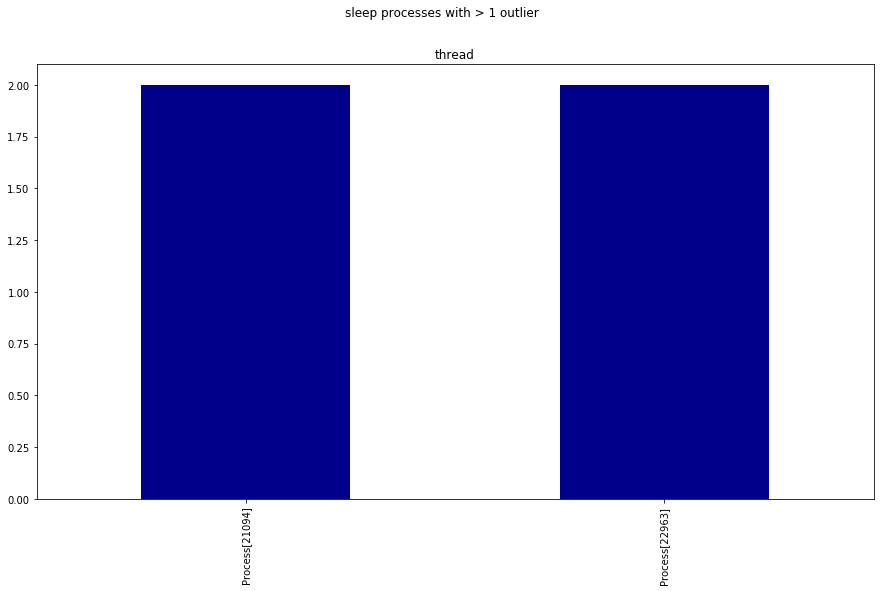

Process[36496] tcsh on pp201- at 2019-02-15 17:48:39.246671 for 4486835576.0
Process[16880] tcsh on pp201- at 2019-02-15 17:50:45.123398 for 2588841.0
Process[26389] tcsh on pp201- at 2019-02-15 17:58:02.063941 for 2326533.0
Process[31065] tcsh on pp201- at 2019-02-15 17:56:09.259943 for 50755.0
Process[12215] tcsh on pp201- at 2019-02-15 17:50:45.034142 for 46814.0
Process[37430] tcsh on pp201- at 2019-02-15 18:16:38.898321 for 46381.0


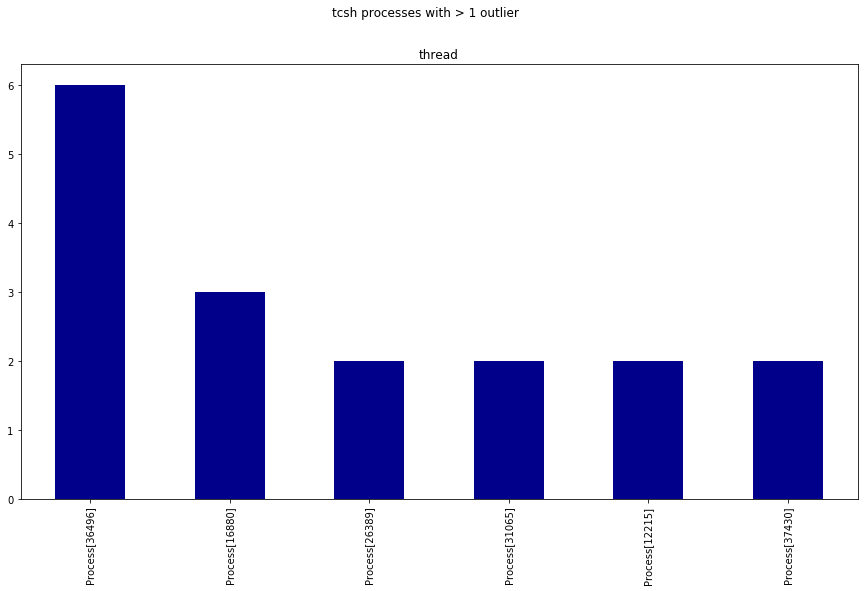

Process[35398] touch on pp201- at 2019-02-15 17:50:25.635870 for 3175.0


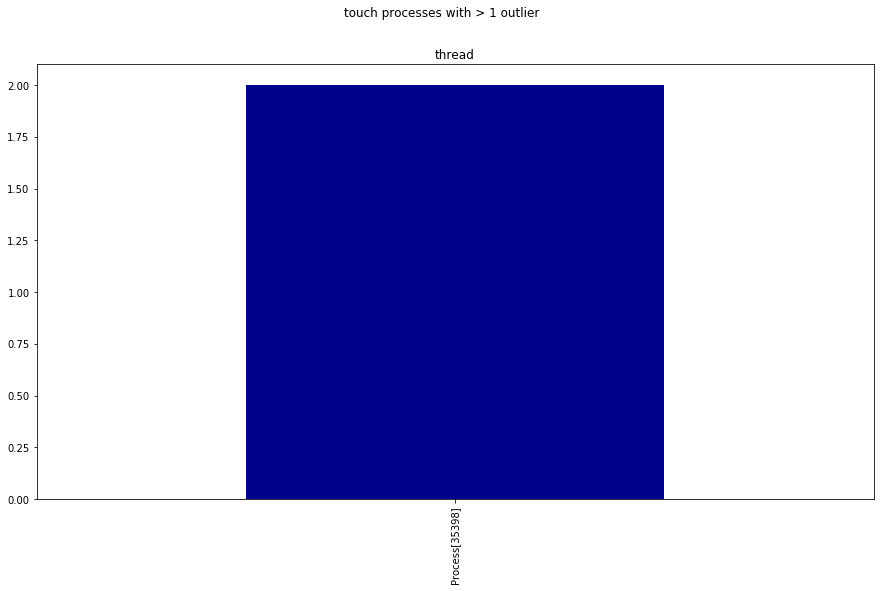

Process[35626] tr on pp201- at 2019-02-15 18:00:59.364389 for 20931.0


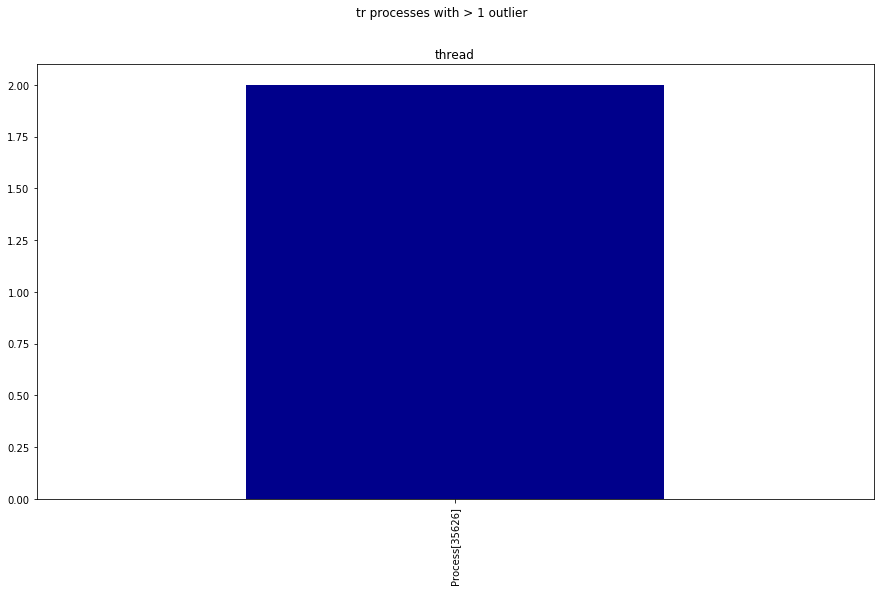

Process[18565] uberftp on pp201- at 2019-02-15 19:00:10.939423 for 2006343.0
Process[12018] uberftp on pp201- at 2019-02-15 18:48:36.189123 for 103669.0


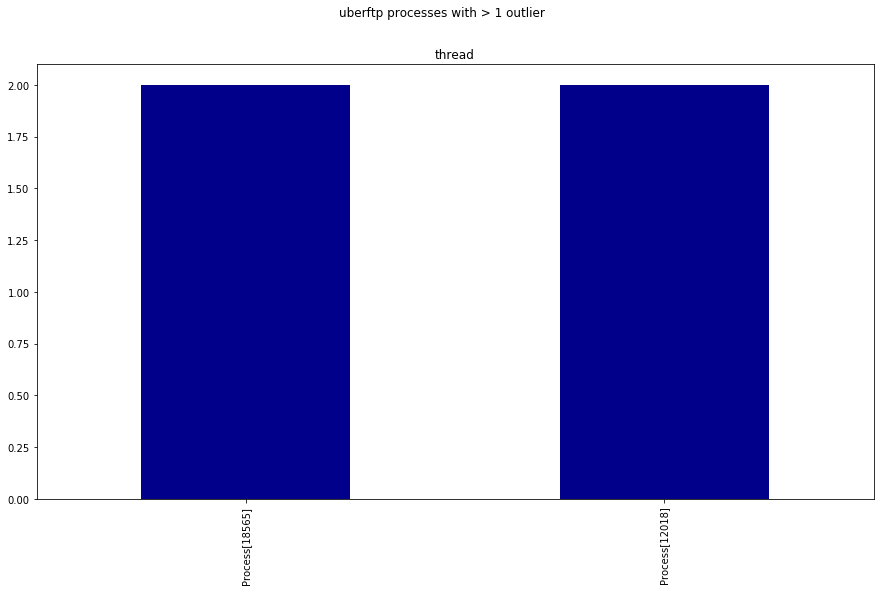

Process[23246] uuidgen on pp201- at 2019-02-15 18:17:40.447010 for 206.0


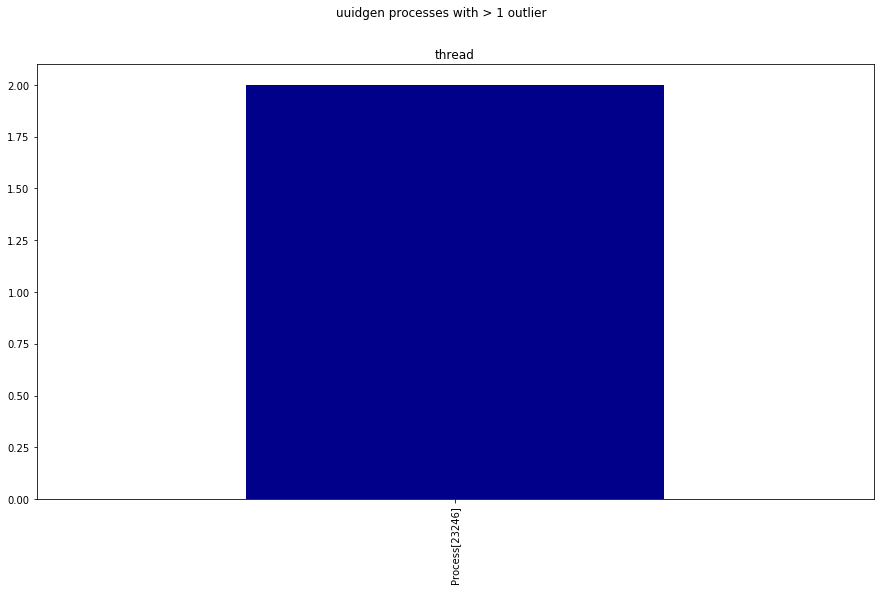

Process[24273] wc on pp201- at 2019-02-15 18:58:28.383015 for 915.0


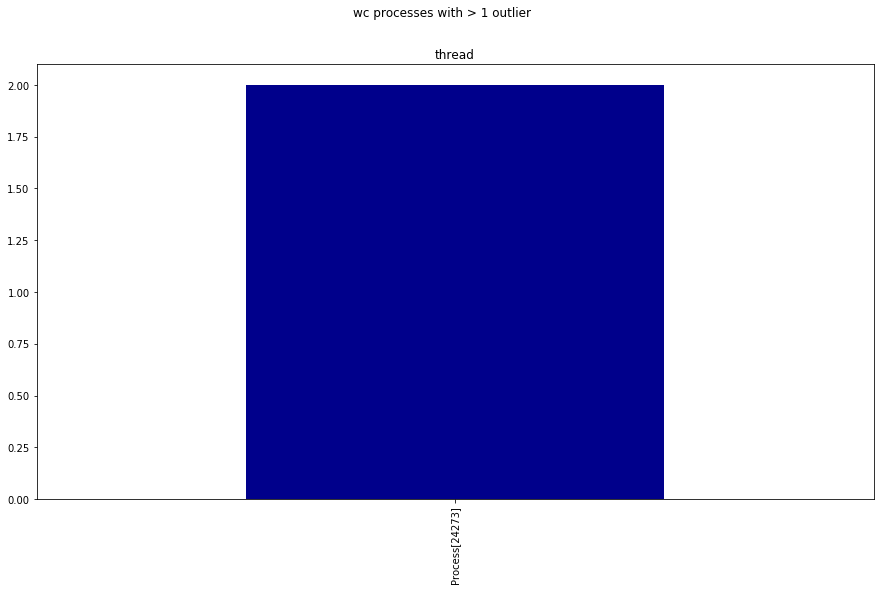

Process[29217] which on pp201- at 2019-02-15 17:57:57.025770 for 126.0
Process[6414] which on pp201- at 2019-02-15 18:13:38.021699 for 220.0


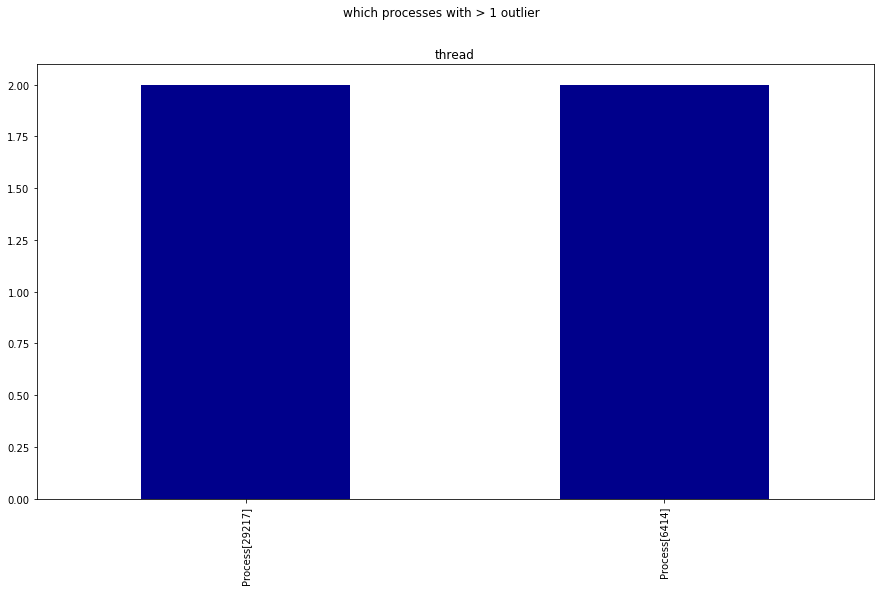

In [167]:
tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","time_waiting","systemtime" ]

def get_df_all_process(jid,exe):
    q = Process.select(lambda p: p.job==jid and p.exename==exe).without_distinct()
#    print "exe",exe,"ran",len(q),"times"
    q = select(p.threads.metrics for p in q).without_distinct()
# order by is important as it always produces the same order of threads
    q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# make lists
    meas = {}
    for m in q[:]:
        if m[1] not in meas:
            meas[m[1]] = [ (m[0], m[2]) ]
        else:
            meas[m[1]].append( (m[0], m[2]) )
# make df
    df = pd.DataFrame()
    for k in tofind:
        if k in meas:
            v,t = zip(*meas[k])
            df[k] = v
            if 'thread' not in df.columns:
                df['thread'] = t
    return df

def filter_job(jid):
    print jid
    q1 = Process.select(lambda p: p.job == jid).without_distinct()
    q1 = select(p.exename for p in q1).order_by(1) #.without_distinct()
    for exe in q1[:]:
        df = get_df_all_process(jid,exe)
        outlier_dfs=[]
        outlier_procs=[]
        outlier_metrics=[]
        for metric in tofind:
            b = get_outliers(df[['thread',metric]].copy(),metric)
#            print_outliers(b,metric)
            outlier_dfs.append(b)
            for index, row in b.iterrows():
                outlier_procs.append(row['thread'].process)
                #, metric))
        #print "Processes with more than one outlier"
        #procs,metrics = zip(*outlier_procs)
        procs = outlier_procs
        dfvc = pd.DataFrame({'thread': procs})
        vc = dfvc['thread'].value_counts()
        vc = vc[ vc != 1]
        for index, value in vc.iteritems():
            print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
        if len(vc):
            vc.plot.bar(subplots=True,title=index.exename+" processes with > 1 outlier",color=['darkblue'])
            plt.show()
#

        
filter_job(js[0])




2 outliers found for delayacct_blkio_time
Outlier stats:
1265000.0
Thread[36035] Process[31944] tcsh(29757) at 2019-02-15 17:48:42.731348 delayacct_blkio_time 10000.0
Thread[41211] Process[36496] tcsh(29570) at 2019-02-15 17:48:39.246671 delayacct_blkio_time 2520000.0

12 outliers found for usertime
Outlier stats:
90319.33333333333
Thread[265] Process[241] tcsh(17230) at 2019-02-15 17:56:06.790720 usertime 18997.0
Thread[537] Process[486] tcsh(5241) at 2019-02-15 18:03:31.668908 usertime 18997.0
Thread[14304] Process[12732] tcsh(11465) at 2019-02-15 18:12:34.015025 usertime 19996.0
Thread[16488] Process[14706] tcsh(2060) at 2019-02-15 18:01:52.127343 usertime 18997.0
Thread[20680] Process[18423] tcsh(32766) at 2019-02-15 18:54:46.909094 usertime 18997.0
Thread[23923] Process[21285] tcsh(32709) at 2019-02-15 18:54:38.002887 usertime 18997.0
Thread[27872] Process[24720] tcsh(4108) at 2019-02-15 18:02:53.484840 usertime 18997.0
Thread[33560] Process[29790] tcsh(1617) at 2019-02-15 18:01:

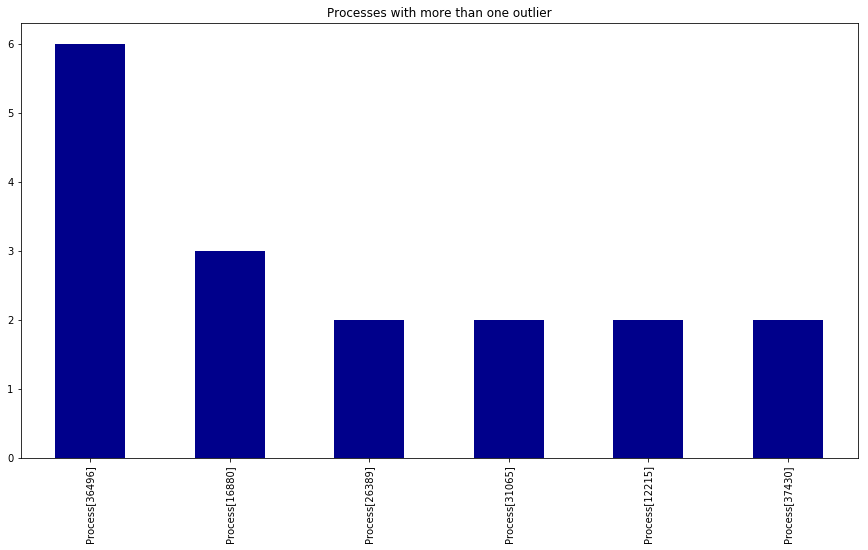

In [122]:


# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="tcsh").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )

# Very important to be sorted by thread object here!

tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","time_waiting","systemtime" ]
df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

# TEST
#t = Thread[41211]
#print t,t.process
#print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

outlier_dfs=[]
outlier_procs=[]
for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    outlier_dfs.append(b)
    for index, row in b.iterrows():
            outlier_procs.append(row['thread'].process) 

#print outliers
print "Processes with more than one outlier"
dfvc = pd.DataFrame({'thread': outlier_procs})
vc = dfvc['thread'].value_counts()
vc = vc[ vc != 1]
#badboys = pd.DataFrame(columns=["key","exe","host","time","duration_us"])
for index, value in vc.iteritems():
        print index,index.exename,"on",index.host.name,"at",index.start,"for",index.duration
ax = vc.plot.bar(title="Processes with more than one outlier",color=['darkblue'])


newdf = df
for d in outlier_dfs:
    newdf = remove_outliers(newdf,d)

print df.describe()
print newdf.describe()

Process[36496] tcsh on pp201- at 2019-02-15 17:48:39.246671 for 4486835576.0
Process[16880] tcsh on pp201- at 2019-02-15 17:50:45.123398 for 2588841.0
Process[26389] tcsh on pp201- at 2019-02-15 17:58:02.063941 for 2326533.0
Process[31065] tcsh on pp201- at 2019-02-15 17:56:09.259943 for 50755.0
Process[12215] tcsh on pp201- at 2019-02-15 17:50:45.034142 for 46814.0
Process[37430] tcsh on pp201- at 2019-02-15 18:16:38.898321 for 46381.0


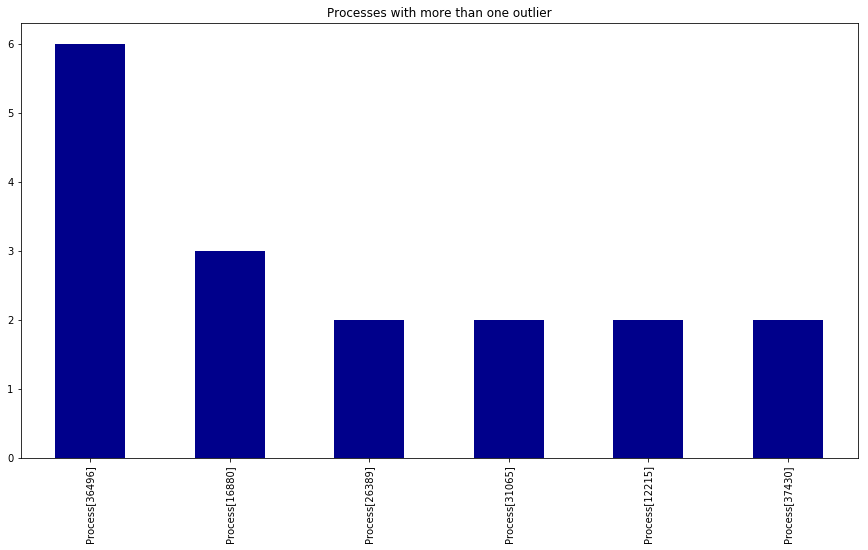

In [117]:


#df = pd.DataFrame({'Duration': q[:]})
#print df.describe()
#array = [durs]
#plt.boxplot(array,showmeans=True,whis=99)
#plt.show()




13080 ['delayacct_blkio_time', 'thread', 'usertime', 'invol_ctxsw', 'time_oncpu', 'time_waiting', 'systemtime']
2 ['thread', 'delayacct_blkio_time']
              thread  delayacct_blkio_time
11190  Thread[36035]               10000.0
12753  Thread[41211]             2520000.0
13078
13078 ['delayacct_blkio_time', 'thread', 'usertime', 'invol_ctxsw', 'time_oncpu', 'time_waiting', 'systemtime']
12 ['thread', 'usertime']
              thread  usertime
100      Thread[265]   18997.0
188      Thread[537]   18997.0
4485   Thread[14304]   19996.0
5173   Thread[16488]   18997.0
6501   Thread[20680]   18997.0
7493   Thread[23923]   18997.0
8668   Thread[27872]   18997.0
10433  Thread[33560]   19996.0
10624  Thread[34227]   18997.0
10781  Thread[34744]   18997.0
12162  Thread[39221]   18997.0
12753  Thread[41211]  872867.0
13067
13067 ['delayacct_blkio_time', 'thread', 'usertime', 'invol_ctxsw', 'time_oncpu', 'time_waiting', 'systemtime']
14 ['thread', 'invol_ctxsw']
              thread  invol_

In [ ]:
#    for key, value in proc_dict.iteritems():
#        if value["threads"] > value["count"]:
#            print key, value["duration"], total, value["duration"]*100.0/total 
#        names["foo"] += 1
#        attr[p.exename] += p.duration



#jobs=select(j for j in Job if j.jobid == jobid)
#for j in jobs:
#    print "Job found:",j.jobname, j.jobid

# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels



In [ ]:
#    
    Process.select(lambda p: p.job == jobid)
    
    j.processes w# lookup job


    doit = False
        for pat in exepatlist:
            if fnmatch.fnmatch(p.exename, pat):
                doit = True
                break
        if not doit:
            continue
total, proc_dict = get_job_processes_full_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', exepatlist=["gl*"])

#print proc_dict
x_val = []
y_val = []
for key, value in proc_dict.iteritems():
    plt.plot([ i for i in range(len(value["start"]))],value["start"])
    plt.show()

print value["start"]

#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





In [ ]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [ ]:
print len(values[:])

In [ ]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 